In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path

import pyomo.environ as pyo

import pvlib
import math
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
import pypsa
import sys
from pyomo.environ import *

In [7]:
Load0 = pd.read_csv('Load.csv', sep=';')
Load = Load0.Load
#Load.to_excel('Demand.xls')

poa=pd.read_csv('verkhoyansk_era5.csv') #index_col=0, #parse_dates=True) #poa_irr.csv

poa_global = poa['Верхоянск.14'][9:]
poa_global = poa_global.astype('float')
poa_global = poa_global.reset_index()
PV = 1.3*poa_global['Верхоянск.14']*0.2*5200/1000

# demand
T1 = 0 #1700, 3700, 3865, 1875, 3605
T2 = 23 #1724, 3724, 3915, 1920, 3650

T = np.array([t for t in range(T1, T2)])

In [8]:
N = 4
N = np.array([n for n in range(0, N)])


p12 = np.arange(0, 321)
p34 = np.arange(0, 521)
p_PV = np.arange(0, 137)
p_BESS = np.arange(0, 151)


DGU1_pmax = 320 #кВт
DGU1_pmin = 0.5*DGU1_pmax

DGU2_pmax = 320 #кВт
DGU2_pmin = 0.5*DGU2_pmax

DGU3_pmax = 520 #кВт
DGU3_pmin = 0.5*DGU3_pmax

DGU4_pmax = 520 #кВт
DGU4_pmin = 0.5*DGU4_pmax

DGU1_fuel =  0.3031*p12
DGU2_fuel =  0.3031*p12
DGU3_fuel = 0.2788*p34
DGU4_fuel = 0.2788*p34

d12_startup_cost = 1000
d34_startup_cost = 2000

d12_shutdown_cost = 1100
d34_shutdown_cost = 2100

Fuel_price = 60 #цена за литр диз.топлива 

ESS_inv = 150

# fig, ax = plt.subplots(1,1)

# ax.plot(DGU1_fuel, label='ДГУ1-2')
# ax.plot(DGU3_fuel, label='ДГУ3-4')

# ax.set_xlim(0, 600)
# ax.set_ylim(0, 500)
# ax.set_xlabel('Мощность, кВт')
# ax.set_ylabel('Расход топлива, л/ч')
# ax.legend(loc='best')
# ax.grid()

In [9]:
m = pyo.ConcreteModel()

output = []

#Граничные условия

d1_up_before = 0
d2_up_before = 2
d3_up_before = 2
d4_up_before = 0

d1_down_before = 3
d2_down_before = 1
d3_down_before = 1
d4_down_before = 3

u1_start = 0
u2_start = 1
u3_start = 1
u4_start = 0

d1_availability_state = 1
d2_availability_state = 1
d3_availability_state = 1
d4_availability_state = 1

d1_min_up_time = 3
d2_min_up_time = 3 
d3_min_up_time = 3 
d4_min_up_time = 3

d1_min_down_time = 3
d2_min_down_time = 3 
d3_min_down_time = 3 
d4_min_down_time = 3 

ess1_availability_state = 1
ess2_availability_state = 1

soc1_before = 50
soc2_before = 50

soc1_after = 80
soc2_after = 80

#Ограничения
def balance(model, i):
    return m.x1[i] + m.x2[i] + m.x3[i] + m.x4[i] + m.bat1_dch[i] - m.bat1_ch[i] + m.bat2_dch[i] - m.bat2_ch[i] + m.PV1[i] + m.PV2[i] + m.PV3[i] + m.PV4[i] + m.PV5[i] + m.PV6[i] + m.PV7[i] == (np.asarray(Load)[i]) # +  

def d1_start_up_cost(model, i):
    if i == T1:
        return m.suc1[i] >= d12_startup_cost*(m.u1[i]-u1_start)
    else:
        return m.suc1[i] >= d12_startup_cost*(m.u1[i]-m.u1[i-1])
    
def d2_start_up_cost(model, i):
    if i == T1:
        return m.suc2[i] >= d12_startup_cost*(m.u2[i]-u2_start)
    else:
        return m.suc2[i] >= d12_startup_cost*(m.u2[i]-m.u2[i-1])
    
def d3_start_up_cost(model, i):
    if i == T1:
        return m.suc3[i] >= d34_startup_cost*(m.u3[i]-u3_start)
    else:
        return m.suc3[i] >= d34_startup_cost*(m.u3[i]-m.u3[i-1])
    
def d4_start_up_cost(model, i):
    if i == T1:
        return m.suc4[i] >= d34_startup_cost*(m.u4[i]-u4_start)
    else:
        return m.suc4[i] >= d34_startup_cost*(m.u4[i]-m.u4[i-1])
    
def d1_shut_down_cost(model, i):
    if i == T1:
        return m.sdc1[i] >= d12_shutdown_cost*(u1_start-m.u1[i])
    else:
        return m.sdc1[i] >= d12_shutdown_cost*(m.u1[i-1]-m.u1[i])

def d2_shut_down_cost(model, i):
    if i == T1:
        return m.sdc2[i] >= d12_shutdown_cost*(u2_start-m.u2[i])
    else:
        return m.sdc2[i] >= d12_shutdown_cost*(m.u2[i-1]-m.u2[i])
    
def d3_shut_down_cost(model, i):
    if i == T1:
        return m.sdc3[i] >= d34_shutdown_cost*(u3_start-m.u3[i])
    else:
        return m.sdc3[i] >= d34_shutdown_cost*(m.u3[i-1]-m.u3[i])

def d4_shut_down_cost(model, i):
    if i == T1:
        return m.sdc4[i] >= d34_shutdown_cost*(u4_start-m.u4[i])
    else:
        return m.sdc4[i] >= d34_shutdown_cost*(m.u4[i-1]-m.u4[i])


# def d1o(model, i):
#     if i == T1:
#         return m.u1[i] - d1_min_up_time*(m.u1[i] - u1_start) >= 0
#     else:

#         return sum(uj) >= d1_min_up_time*(m.u1[i] - m.u1[i-1])


# def d2o(model, i):
#     if i == T1:
#         return (1-m.u3[i]) >= d3_min_down_time*(u3_start - m.u3[i])
#     if i > T2-3:
#         return m.u3[i+1] + m.u3[i+2] + m.u3[i+3]  >= d1_min_down_time*(m.u1[i-1] - m.u1[i])

# def d1_partial(model, i):
#     return m.x1

def d1_min_up_time_c(model, i):
    if i == T1:
        return (d1_up_before - d1_min_up_time)*(u1_start - m.u1[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u1[i-1])
        for j in range(T1, i):
            uj.append(m.u1[j])
        return ((sum(uj) - d1_min_up_time)*(m.u1[i-1] - m.u1[i])) >= 0
    else:
        return ((m.u1[i-1] + m.u1[i-2] + m.u1[i-3] - d1_min_up_time)*(m.u1[i-1] - m.u1[i])) >= 0
    
def d2_min_up_time_c(model, i):
    if i == T1:
        return (d2_up_before - d2_min_up_time)*(u2_start - m.u2[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u2[i-1])
        for j in range(T1, i):
            uj.append(m.u2[j])
        return ((sum(uj) - d2_min_up_time)*(m.u2[i-1] - m.u2[i])) >= 0
    else:
        return ((m.u2[i-1] + m.u2[i-2] + m.u2[i-3] - d2_min_up_time)*(m.u2[i-1] - m.u2[i])) >= 0
    
def d3_min_up_time_c(model, i):
    if i == T1:
        return (d3_up_before - d3_min_up_time)*(u3_start - m.u3[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u3[i-1])
        for j in range(T1, i):
            uj.append(m.u3[j])
        return ((sum(uj) - d3_min_up_time)*(m.u3[i-1] - m.u3[i])) >= 0
    else:
        return ((m.u3[i-1] + m.u3[i-2] + m.u3[i-3] - d3_min_up_time)*(m.u3[i-1] - m.u3[i])) >= 0

def d4_min_up_time_c(model, i):
    if i == T1:
        return (d4_up_before - d4_min_up_time)*(u4_start - m.u4[i]) >= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u4[i-1])
        for j in range(T1, i):
            uj.append(m.u4[j])
        return ((sum(uj) - d4_min_up_time)*(m.u4[i-1] - m.u4[i])) >= 0
    else:
        return ((m.u4[i-1] + m.u4[i-2] + m.u4[i-3] - d4_min_up_time)*(m.u4[i-1] - m.u4[i])) >= 0

def d1_min_down_time_c(model, i):
    if i == T1:
        return (d1_down_before + d1_min_down_time)*(-u1_start + m.u1[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u1[i-1])
        for j in range(T1, i):
            uj.append(m.u1[j])
        return ((sum(uj) - 2 + d1_min_down_time)*(-m.u1[i-1] + m.u1[i])) <= 0
    else:
        return ((m.u1[i-1] + m.u1[i-2] + m.u1[i-3] - 3 + d1_min_down_time)*(-m.u1[i-1] + m.u1[i])) <= 0

def d2_min_down_time_c(model, i):
    if i == T1:
        return (d2_down_before + d2_min_down_time)*(-u2_start + m.u2[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u2[i-1])
        for j in range(T1, i):
            uj.append(m.u2[j])
        return ((sum(uj) - 2 + d2_min_down_time)*(-m.u2[i-1] + m.u2[i])) <= 0
    else:
        return ((m.u2[i-1] + m.u2[i-2] + m.u2[i-3] - 3 + d2_min_down_time)*(-m.u2[i-1] + m.u2[i])) <= 0

def d3_min_down_time_c(model, i):
    if i == T1:
        return (d3_down_before + d3_min_down_time)*(-u3_start + m.u3[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u3[i-1])
        for j in range(T1, i):
            uj.append(m.u3[j])
        return ((sum(uj) - 2 + d3_min_down_time)*(-m.u3[i-1] + m.u3[i])) <= 0
    else:
        return ((m.u3[i-1] + m.u3[i-2] + m.u3[i-3] - 3 + d3_min_down_time)*(-m.u3[i-1] + m.u3[i])) <= 0

def d4_min_down_time_c(model, i):
    if i == T1:
        return (d4_down_before + d4_min_down_time)*(-u4_start + m.u4[i]) <= 0
    elif i <= T1+2:
        uj = []
        uj.append(m.u4[i-1])
        for j in range(T1, i):
            uj.append(m.u4[j])
        return ((sum(uj) - 2 + d4_min_down_time)*(-m.u4[i-1] + m.u4[i])) <= 0
    else:
        return ((m.u4[i-1] + m.u4[i-2] + m.u4[i-3] - 3 + d4_min_down_time)*(-m.u4[i-1] + m.u4[i])) <= 0

#ограничение глубины разряда СНЭ  
def soc1_ctrl(model, i):
    if i == T1:
        return m.soc1[i] == soc1_before - 100*m.bat1_dch[i]/700 + 100*m.bat1_ch[i]/700
    else:
        return m.soc1[i] == m.soc1[i-1] - 100*m.bat1_dch[i]/700 + 100*m.bat1_ch[i]/700

def soc2_ctrl(model, i):
    if i == T1:
        return m.soc2[i] == soc2_before - 100*m.bat2_dch[i]/700 + 100*m.bat2_ch[i]/700
    else:
        return m.soc2[i] == m.soc2[i-1] - 100*m.bat2_dch[i]/700 + 100*m.bat2_ch[i]/700
    
#СНЭ не должна заряжаться и разряжаться одновременно     
def ch_x_dch1 (model, i):
    return m.bat1_ch[i] * m.bat1_dch[i] == 0

def ch_x_dch2 (model, i):
    return m.bat2_ch[i] * m.bat2_dch[i] == 0

def ess12(model, i):
    return m.bat1_dch[i] - m.bat2_ch[i] - m.bat1_dch[i] == 0 #m.bat1_dch[i] - m.bat2_ch[i] - m.bat1_dch[i] <= 0 

def ess21(model, i):
    return m.bat2_dch[i] - m.bat1_ch[i] - m.bat2_dch[i] == 0 

#если СНЭ заряжена не на 100%, не ограничиваем инверторы СЭС 
def curtailment_control1 (model, i):
    return m.PV1[i]+ m.PV2[i]+m.PV3[i]+m.PV4[i]+m.PV5[i]+m.PV6[i]+m.PV7[i] - PV[i] - m.bat1_ch[i]/ESS_inv  <= 0 

def curtailment_control2 (model, i):
    return m.PV1[i]+ m.PV2[i]+m.PV3[i]+m.PV4[i]+m.PV5[i]+m.PV6[i]+m.PV7[i] - PV[i] - m.bat2_ch[i]/ESS_inv  <= 0 

def d1_availability (model, i):
    return m.u1[i] == m.u1[i] * d1_availability_state

def d2_availability (model, i):
    return m.u2[i] == m.u2[i] * d2_availability_state

def d3_availability (model, i):
    return m.u3[i] == m.u3[i] * d3_availability_state

def d4_availability (model, i):
    return m.u4[i] == m.u4[i] * d4_availability_state


def ess1_availability (model, i):
    return m.bat1_dch[i] + m.bat1_ch[i] == (m.bat1_dch[i] + m.bat1_ch[i]) * ess1_availability_state

def ess2_availability (model, i):
    return m.bat2_dch[i] + m.bat2_ch[i] == (m.bat2_dch[i] + m.bat2_ch[i]) * ess2_availability_state

def cycle1(model, i):
    return m.soc1[T1+T2-T1-1] >= soc1_after

def cycle2(model, i):
    return m.soc2[T1+T2-T1-1] >= soc2_after

def as_one1(model, i):
    return m.bat1_dch[i] == m.bat2_dch[i] 

def as_one2(model, i):
    return m.bat1_ch[i] == m.bat2_ch[i] 

def unit_commitment():
    
    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    m.x1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU1_pmax))
    m.u1 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU2_pmax))
    m.u2 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU3_pmax))
    m.u3 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.x4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, DGU4_pmax))
    m.u4 = pyo.Var(m.T, domain=pyo.Binary)
    
    m.bat1_dch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    m.bat1_ch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    
    m.bat2_dch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    m.bat2_ch = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, ESS_inv))
    
    m.soc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (50, 100))
    m.soc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (50, 100))
    
    m.suc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_startup_cost))
    m.suc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_startup_cost))
    m.suc3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_startup_cost))
    m.suc4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_startup_cost))
    
    m.sdc1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_shutdown_cost))
    m.sdc2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d12_shutdown_cost))
    m.sdc3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_shutdown_cost))
    m.sdc4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, d34_shutdown_cost))
    
    m.PV1 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV2 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV3 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV4 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV5 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV6 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    m.PV7 = pyo.Var(m.T, domain=pyo.NonNegativeReals, bounds = (0, 136))
    
    #m.PV1_s = pyo.Var(m.T, domain=pyo.Binary)
    #m.PV2_s = pyo.Var(m.T, domain=pyo.Binary)
    
    
    # целевая функция
    m.cost = pyo.Objective(expr = sum(Fuel_price*((0.0219*DGU1_pmax*m.u1[t] + 0.3125*m.x1[t]) + (0.0219*DGU2_pmax*m.u2[t] + 0.3125*m.x2[t]) +
                                      (0.049*DGU3_pmax*m.u3[t] + 0.2788*m.x3[t]) + (0.049*DGU4_pmax*m.u4[t] + 0.2788*m.x4[t])) + m.suc1[t] +
                                      m.suc2[t] + m.suc3[t] + m.suc4[t] + m.sdc1[t] +
                                      m.sdc2[t] + m.sdc3[t] + m.sdc4[t] +
                                      27432*0.000033*(m.bat1_ch[t]+m.bat1_dch[t]) + 27432*0.000033*(m.bat2_ch[t]+m.bat2_dch[t]) +
                                      m.u1[t]*100 + m.u2[t]*100 + m.u3[t]*100 + m.u4[t]*100
                                      for t in m.T), sense=pyo.minimize)
    
    
    m.demand = pyo.Constraint(m.T, rule=balance)
    
    
    m.lb1 = pyo.Constraint(m.T, rule=lambda m, t: DGU1_pmin*m.u1[t] <= m.x1[t])
    m.ub1 = pyo.Constraint(m.T, rule=lambda m, t: DGU1_pmax*m.u1[t] >= m.x1[t])
    m.lb2 = pyo.Constraint(m.T, rule=lambda m, t: DGU2_pmin*m.u2[t] <= m.x2[t])
    m.ub2 = pyo.Constraint(m.T, rule=lambda m, t: DGU2_pmax*m.u2[t] >= m.x2[t])
    m.lb3 = pyo.Constraint(m.T, rule=lambda m, t: DGU3_pmin*m.u3[t] <= m.x3[t])
    m.ub3 = pyo.Constraint(m.T, rule=lambda m, t: DGU3_pmax*m.u3[t] >= m.x3[t])
    m.lb4 = pyo.Constraint(m.T, rule=lambda m, t: DGU4_pmin*m.u4[t] <= m.x4[t])
    m.ub4 = pyo.Constraint(m.T, rule=lambda m, t: DGU4_pmax*m.u4[t] >= m.x4[t])
    
    m.pv1 = pyo.Constraint(m.T, rule=lambda m, t: m.PV1[t] <= PV[t]/7)
    m.pv2 = pyo.Constraint(m.T, rule=lambda m, t: m.PV2[t] <= PV[t]/7)
    m.pv3 = pyo.Constraint(m.T, rule=lambda m, t: m.PV3[t] <= PV[t]/7)
    m.pv4 = pyo.Constraint(m.T, rule=lambda m, t: m.PV4[t] <= PV[t]/7)
    m.pv5 = pyo.Constraint(m.T, rule=lambda m, t: m.PV5[t] <= PV[t]/7)
    m.pv6 = pyo.Constraint(m.T, rule=lambda m, t: m.PV6[t] <= PV[t]/7)
    m.pv7 = pyo.Constraint(m.T, rule=lambda m, t: m.PV7[t] <= PV[t]/7)
    
    m.pv1_curtailment = pyo.Constraint(m.T, rule=curtailment_control1)
    m.pv2_curtailment = pyo.Constraint(m.T, rule=curtailment_control2)
    
    m.min_up_time_d1 = pyo.Constraint(m.T, rule=d1_min_up_time_c)
    m.min_up_time_d2 = pyo.Constraint(m.T, rule=d2_min_up_time_c)
    m.min_up_time_d3 = pyo.Constraint(m.T, rule=d3_min_up_time_c)
    m.min_up_time_d4 = pyo.Constraint(m.T, rule=d4_min_up_time_c)
    
    m.min_down_time_d1 = pyo.Constraint(m.T, rule=d1_min_down_time_c)
    m.min_down_time_d2 = pyo.Constraint(m.T, rule=d2_min_down_time_c)
    m.min_down_time_d3 = pyo.Constraint(m.T, rule=d3_min_down_time_c)
    m.min_down_time_d4 = pyo.Constraint(m.T, rule=d4_min_down_time_c)
    
    m.su1 = pyo.Constraint(m.T, rule=d1_start_up_cost)
    m.su2 = pyo.Constraint(m.T, rule=d2_start_up_cost)
    m.su3 = pyo.Constraint(m.T, rule=d3_start_up_cost)
    m.su4 = pyo.Constraint(m.T, rule=d4_start_up_cost)
    
    m.sd1 = pyo.Constraint(m.T, rule=d1_shut_down_cost)
    m.sd2 = pyo.Constraint(m.T, rule=d2_shut_down_cost)
    m.sd3 = pyo.Constraint(m.T, rule=d3_shut_down_cost)
    m.sd4 = pyo.Constraint(m.T, rule=d4_shut_down_cost)
    
    m.d1_ava = pyo.Constraint(m.T, rule=d1_availability)
    m.d2_ava = pyo.Constraint(m.T, rule=d2_availability)
    m.d3_ava = pyo.Constraint(m.T, rule=d3_availability)
    m.d4_ava = pyo.Constraint(m.T, rule=d4_availability)
    
    m.soc1_ctrl = pyo.Constraint(m.T, rule=soc1_ctrl)
    m.soc2_ctrl = pyo.Constraint(m.T, rule=soc2_ctrl)
    m.chdch1 = pyo.Constraint(m.T, rule=ch_x_dch1)
    m.chdch2 = pyo.Constraint(m.T, rule=ch_x_dch2)
    #m.ess12 = pyo.Constraint(m.T, rule=ess12)
    #m.ess21 = pyo.Constraint(m.T, rule=ess21)
    m.ess1_ava = pyo.Constraint(m.T, rule=ess1_availability)
    m.ess2_ava = pyo.Constraint(m.T, rule=ess2_availability)
    #m.d1_cstr1 = pyo.Constraint(m.T, rule=d1_cstr1)
    #m.curt1 = pyo.Constraint(m.T, rule=curtailment_control1) 
    #m.ess1_cyc = pyo.Constraint(m.T, rule=cycle1)
    #m.ess2_cyc = pyo.Constraint(m.T, rule=cycle2)
    
    m.as_one1 = pyo.Constraint(m.T, rule=as_one1)
    m.as_one2 = pyo.Constraint(m.T, rule=as_one2)
    
    return m

m = unit_commitment()


# Create a model instance and optimize
#instance = m.create_instance("d.dat")

opt =  pyo.SolverFactory('scipampl',executable=r'C:\coding\scipampl-7.0.0.win.x86_64.intel.opt.spx2')
#opt.options["parallel/mode"] = 1
#opt.options['numthreads'] = 8
#opt.options['parallel/maxnthreads'] = 4
#opt.options['limits/gap'] = 0.05


results = opt.solve(m, logfile=r'couenne_logg.log', tee=True, timelimit=6000, keepfiles=True)
results.write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()



# Extract model output in list
Date = list(Load[T].index)
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load[T1:T2]
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Load[T1:T2].index
dfout['Load'] = Load[T1:T2]


Solver log file: 'couenne_logg.log'
Solver solution file: 'C:\Users\NARYNB~1\AppData\Local\Temp\tmp5byhxubq.pyomo.sol'
Solver problem files: ('C:\\Users\\NARYNB~1\\AppData\\Local\\Temp\\tmp5byhxubq.pyomo.nl',)
SCIP version 7.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.0] [GitHash: 0bc4dc9c65]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 6535a3c8]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  bliss 0.73p          Computing Graph Automorphism Groups by T. Junttila and P. Kaski (http://www.tcs.hut.fi/Software/bliss/)
  Ipopt 3.13.1         Interior Point Optimizer developed by A. Waechter et.al. (www.coin-or.org/Ipopt)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of paramet

Результаты оптимизации
Суточный расход дизельного топлива: ----------------------------------- > 4882.0 л


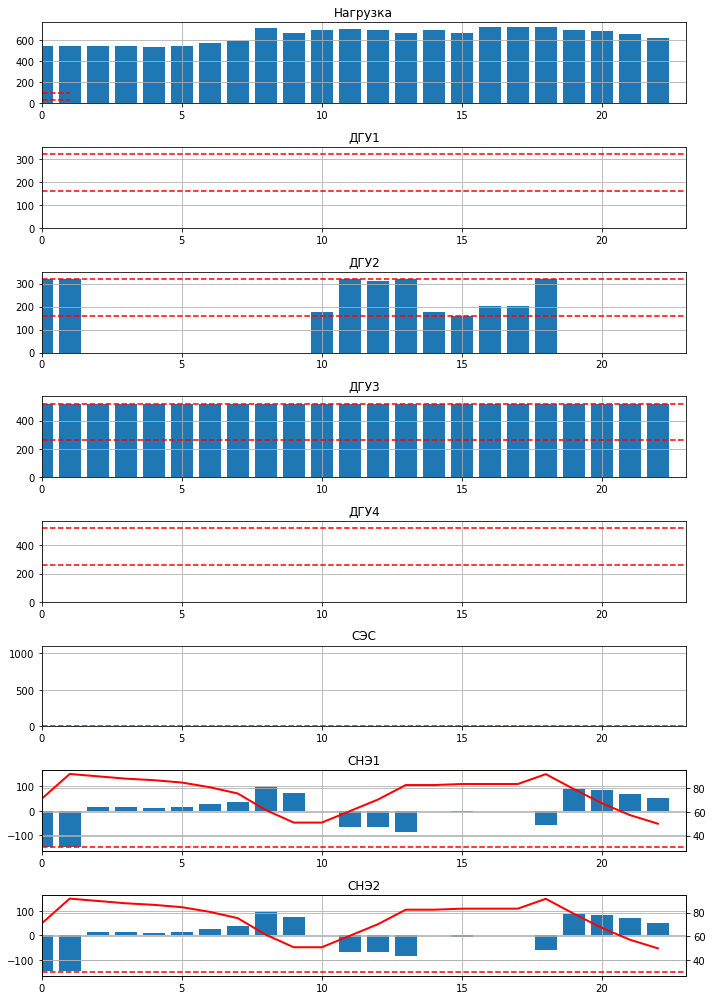

In [10]:
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(8, 1, figsize=(10, 14))

ax[0].bar(T, [Load[t] for t in T])
ax[0].set_xlim(T1, T2)
ax[0].set_ylim(0, 1.1*700)
ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[0].set_title('Нагрузка')

ax[1].bar(T, [m.x1[t]() for t in T])
ax[1].set_xlim(T1, T2)
ax[1].set_ylim(0, 1.1*DGU1_pmax)
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmax, DGU1_pmax]), 'r--')
ax[1].plot(ax[0].get_xlim(), np.array([DGU1_pmin, DGU1_pmin]), 'r--')
ax[1].set_title('ДГУ1')

ax[2].bar(T, [m.x2[t]() for t in T])
ax[2].set_xlim(T1, T2)
ax[2].set_ylim(0, 1.1*DGU2_pmax)
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmax, DGU2_pmax]), 'r--')
ax[2].plot(ax[1].get_xlim(), np.array([DGU2_pmin, DGU2_pmin]), 'r--')
ax[2].set_title('ДГУ2')

ax[3].bar(T, [m.x3[t]() for t in T])
ax[3].set_xlim(T1, T2)
ax[3].set_ylim(0, 1.1*DGU3_pmax)
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmax, DGU3_pmax]), 'r--')
ax[3].plot(ax[1].get_xlim(), np.array([DGU3_pmin, DGU3_pmin]), 'r--')
ax[3].set_title('ДГУ3')

ax[4].bar(T, [m.x4[t]() for t in T])
ax[4].set_xlim(T1, T2)
ax[4].set_ylim(0, 1.1*DGU4_pmax)
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmax, DGU4_pmax]), 'r--')
ax[4].plot(ax[1].get_xlim(), np.array([DGU4_pmin, DGU4_pmin]), 'r--')
ax[4].set_title('ДГУ4')

ax[5].bar(T, [m.pv1[t]()+ m.pv2[t]()+m.pv3[t]()+m.pv4[t]()+m.pv5[t]()+m.pv6[t]()+m.pv7[t]() for t in T])
ax[5].set_xlim(T1, T2)
ax[5].set_ylim(0, 1.1*1000)
ax[5].bar(T, [PV[t] for t in T], alpha=0.5)
ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')

ax[5].set_title('СЭС')

ax2 = ax[6].twinx()
ax2.plot(T, [m.soc1[t]() for t in T], color='red', linewidth=2)
ax[6].bar(T, [m.bat1_dch[t]()-m.bat1_ch[t]() for t in T])
ax[6].set_xlim(T1, T2)
ax[6].set_ylim(-1.1*150, 1.1*150)
#ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[6].set_title('СНЭ1')

ax3 = ax[7].twinx()
ax3.plot(T, [m.soc2[t]() for t in T], color='red', linewidth=2)
ax[7].bar(T, [m.bat2_dch[t]()-m.bat2_ch[t]() for t in T])
ax[7].set_xlim(T1, T2)
ax[7].set_ylim(-1.1*150, 1.1*150)
#ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
ax[7].set_title('СНЭ2')

u1 = np.fromiter(m.u1.get_values().values(), dtype=float)
u2 = np.fromiter(m.u2.get_values().values(), dtype=float)
u3 = np.fromiter(m.u3.get_values().values(), dtype=float)
u4 = np.fromiter(m.u4.get_values().values(), dtype=float)

fig.tight_layout()
#dfout.plot(kind='bar')m = pyo.ConcreteModel()

#m.constraint.pprint()

fuel_cc = sum((0.0219*DGU1_pmax*u1 + 0.3125*dfout.d1) + (0.0219*DGU2_pmax*u2 + 0.3125*dfout.d2) + (0.049*DGU3_pmax*u3 + 0.2788*dfout.d3) + (0.049*DGU4_pmax*u4 + 0.2788*dfout.d4))

#instance.solutions.store_to(results)
#print(results)

# print(results)
print('Результаты оптимизации')
#print('Оптимизированные операционные затраты за сутки: --------------------- >', '242214 руб.')
print('Суточный расход дизельного топлива: ----------------------------------- >', round(fuel_cc, 0), 'л')

In [11]:
import numpy as np
import pandas as pd
import random
import os
import time
from datetime import datetime
import logging
import traceback
from shutil import copyfile

start_time = time.time()

def conv(x):
    return x.replace(',', '.').encode()

for i in range(0,10000000000000000000000000):
    fileName = 'C:\PROJECT\PathFromWrite.csv'
    try:
        if os.path.isfile(fileName):
            originalTime = os.path.getmtime(fileName)
            print('СТАРТ ОТСЛЕЖИВАНИЯ ИЗМЕНЕНИЙ', datetime.now())
            inn=np.genfromtxt((conv(x) for x in open('C:\PROJECT\PathFromWrite.csv')), delimiter=',')
            out0=pd.read_csv('C:\PROJECT\Path.csv', delimiter=';')
            out=np.array(out0)
            
            
            Load = [0,0,0,0,0]
            Load[0] = inn[0:7].sum()+inn[29:31].sum()+inn[43:47].sum()+inn[67]+inn[69]+inn[71]
            Load[1] = Load[0] + random.uniform(-65.0,65.0)*(-1)
            Load[2] = Load[0] + random.uniform(-65.0,65.0)*(-1)
            Load[3] = Load[0] + random.uniform(-65.0,65.0)*(-1)
            Load[4] = Load[0] + random.uniform(-65.0,65.0)*(-1)
            
            
            PV=[inn[0:7].sum(), inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1), inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1),
               inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1),inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1)]
            soc1_before = inn[35]/10
            soc2_before = inn[36]/10

            if inn[51]==30:
                u1_start = 1
                d1_up_before = 2
                d1_down_before = 1
            else:
                u1_start = 0
                d1_up_before = 0
                d1_down_before = 3
            if inn[52]==30:
                u2_start = 1
                d2_up_before = 2
                d2_down_before = 1
            else:
                u2_start = 0
                d2_up_before = 0
                d2_down_before = 3
            if inn[53]==30:
                u3_start = 1
                d3_up_before = 2
                d3_down_before = 0
            else:
                u3_start = 0
                d3_up_before = 0
                d3_down_before = 3
            if inn[54]==30:
                u4_start = 1
                d4_up_before = 2
                d4_down_before = 0
            else:
                u4_start = 0
                d4_up_before = 0
                d4_down_before = 3

            #ava states
            d1_availability_state = inn[63]
            d2_availability_state = inn[64]
            d3_availability_state = inn[65]
            d4_availability_state = inn[66]

            ess1_availability_state = inn[41]
            ess2_availability_state = inn[42]
            
            m = unit_commitment()


            # Create a model instance and optimize
            #instance = m.create_instance("d.dat")

            opt =  pyo.SolverFactory('scipampl')
            #opt.options["parallel/mode"] = 1
            #opt.options['numthreads'] = 8
            #opt.options['parallel/maxnthreads'] = 4
            #opt.options['limits/gap'] = 0.05


            results = opt.solve(m, logfile=os.path.join('C:\\', 'Project', 'ошибки\\'), tee=True, timelimit=6000, keepfiles=True)
            results.write()
            #pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

            # Extract model output in list
            Date = list([0,1,2,3,4])
            output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                            m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
                          m.bat1_ch.get_values().values()]) 
                            #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


            dfout = pd.DataFrame()
            #dfout.index=Load[T].index
            dfout['Load'] = Load
            dfout['d1'] = m.x1.get_values().values()
            dfout['d2'] = m.x2.get_values().values()
            dfout['d3'] = m.x3.get_values().values()
            dfout['d4'] = m.x4.get_values().values()
            # dfout['d1_suc'] = m.suc1.get_values().values()
            # dfout['d2_suc'] = m.suc2.get_values().values()
            # dfout['d3_suc'] = m.suc3.get_values().values()
            # dfout['d4_suc'] = m.suc4.get_values().values()
            # dfout['d1_sdc'] = m.sdc1.get_values().values()
            # dfout['d2_sdc'] = m.sdc2.get_values().values()
            # dfout['d3_sdc'] = m.sdc3.get_values().values()
            # dfout['d4_sdc'] = m.sdc4.get_values().values()
            dfout['bat1_dch'] = m.bat1_dch.get_values().values()
            dfout['bat1_ch'] = m.bat1_ch.get_values().values()
            dfout['bat2_dch'] = m.bat2_dch.get_values().values()
            dfout['bat2_ch'] = m.bat2_ch.get_values().values()
            dfout['soc1'] = m.soc1.get_values().values()
            dfout['soc2'] = m.soc2.get_values().values()
            dfout['pv1'] = m.PV1.get_values().values()
            dfout['pv2'] = m.PV2.get_values().values()
            dfout['pv3'] = m.PV3.get_values().values()
            dfout['pv4'] = m.PV4.get_values().values()
            dfout['pv5'] = m.PV5.get_values().values()
            dfout['pv6'] = m.PV6.get_values().values()
            dfout['pv7'] = m.PV7.get_values().values()
            dfout['bat1_ch'] = -dfout['bat1_ch']
            dfout['bat2_ch'] = -dfout['bat2_ch']
            #dfout['dd1'] = m.u1.get_values().values()

            dfout.index = Date
            dfout['Load'] = Load

            out[0][0] = dfout.iloc[1][5]+dfout.iloc[1][6]
            out[0][1] = dfout.iloc[1][7]+dfout.iloc[1][8]
            out[0][2] = 1
            out[0][3] = 1
            out[0][4] = 0
            out[0][5] = 0
            out[0][6] = 1
            out[0][7] = 1
            out[0][8] = bool(np.fromiter(m.u1.get_values().values(), dtype=float)[1])
            out[0][9] = bool(np.fromiter(m.u2.get_values().values(), dtype=float)[1])
            out[0][10] = bool(np.fromiter(m.u3.get_values().values(), dtype=float)[1])
            out[0][11] = bool(np.fromiter(m.u4.get_values().values(), dtype=float)[1])
            out[0][12] = int(100*dfout.iloc[1][11]/136)
            out[0][13] = int(100*dfout.iloc[1][12]/136)
            out[0][14] = int(100*dfout.iloc[1][13]/136)
            out[0][15] = int(100*dfout.iloc[1][14]/136)
            out[0][16] = int(100*dfout.iloc[1][15]/136)
            out[0][17] = int(100*dfout.iloc[1][16]/136)
            out[0][18] = int(100*dfout.iloc[1][17]/136)
            out[0][19] = 128
            out[0][20] = 128
            out[0][21] = 128
            out[0][22] = 128
            out[0][23] = 128
            out[0][24] = 128
            out[0][25] = 128
            out[0][26] = 0
            out[0][27] = 0
            out[0][28] = 0
            out[0][29] = 0
            out[0][30] = 0
            out[0][31] = 0
            out[0][32] = 0
            out[0][33] = 1
            out[0][34] = 1
            out[0][35] = 1
            out[0][36] = 1
            out[0][37] = 1
            out[0][38] = 1
            out[0][39] = 1
            out[0][40] = 0
            out[0][41] = 0
            out[0][42] = 0
            out[0][43] = 0
            out[0][44] = 0
            out[0][45] = 0
            out[0][46] = 0

            out0[:]=[out[0]]
                    
            out0.to_csv('C:\PROJECT\Path.csv',sep=';',index=False, decimal=',')
                    #np.savetxt("C:\PROJECT\Path.csv", np.round(np.genfromtxt('C:\PROJECT\PathFromWrite.csv', delimiter=',')**2, decimals=0), delimiter=",", fmt='%i')
            originalTime = os.path.getmtime(fileName)
            print('Выходные данные сохранены в C:\PROJECT\Path.csv')
            
            
            
            while(True):
                if(os.path.getmtime(fileName) > originalTime):
                    print('file C:\PROJECT\PathFromWrite.csv was changed')
                    
                    inn=np.genfromtxt((conv(x) for x in open('C:\PROJECT\PathFromWrite.csv')), delimiter=',')
                    out0=pd.read_csv('C:\PROJECT\Path.csv', delimiter=';')
                    out=np.array(out0)
                    
                    
                    
                    T = np.array([t for t in range(0, 5)])

                    Load = [0,0,0,0,0]
                    Load[0] = inn[0:7].sum()+inn[29:31].sum()+inn[43:47].sum()+inn[67]+inn[69]+inn[71]
                    Load[1] = Load[0] + random.uniform(-65.0,65.0)*(-1)
                    Load[2] = Load[0] + random.uniform(-65.0,65.0)*(-1)
                    Load[3] = Load[0] + random.uniform(-65.0,65.0)*(-1)
                    Load[4] = Load[0] + random.uniform(-65.0,65.0)*(-1)

                    PV=[inn[0:7].sum(), inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1), inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1),
                       inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1),inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1)]
                    soc1_before = inn[35]/10
                    soc2_before = inn[36]/10

                    if inn[51]==30:
                        u1_start = 1
                        d1_up_before = 2
                        d1_down_before = 1
                    else:
                        u1_start = 0
                        d1_up_before = 0
                        d1_down_before = 3
                    if inn[52]==30:
                        u2_start = 1
                        d2_up_before = 2
                        d2_down_before = 1
                    else:
                        u2_start = 0
                        d2_up_before = 0
                        d2_down_before = 3
                    if inn[53]==30:
                        u3_start = 1
                        d3_up_before = 2
                        d3_down_before = 0
                    else:
                        u3_start = 0
                        d3_up_before = 0
                        d3_down_before = 3
                    if inn[54]==30:
                        u4_start = 1
                        d4_up_before = 2
                        d4_down_before = 0
                    else:
                        u4_start = 0
                        d4_up_before = 0
                        d4_down_before = 3

                    #ava states
                    d1_availability_state = inn[63]
                    d2_availability_state = inn[64]
                    d3_availability_state = inn[65]
                    d4_availability_state = inn[66]

                    ess1_availability_state = inn[41]
                    ess2_availability_state = inn[42]

                    m = unit_commitment()


                    # Create a model instance and optimize
                    #instance = m.create_instance("d.dat")

                    opt =  pyo.SolverFactory('scipampl')
                    #opt.options["parallel/mode"] = 1
                    #opt.options['numthreads'] = 8
                    #opt.options['parallel/maxnthreads'] = 4
                    #opt.options['limits/gap'] = 0.05


                    results = opt.solve(m, logfile=os.path.join('C:\\', 'Project', 'ошибки\\'), tee=True, timelimit=6000, keepfiles=True)
                    results.write()
                    #pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()
                    
                    # Extract model output in list
                    Date = list([0,1,2,3,4])
                    output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                                    m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
                                  m.bat1_ch.get_values().values()]) 
                                    #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


                    dfout = pd.DataFrame()
                    #dfout.index=Load[T].index
                    dfout['Load'] = Load
                    dfout['d1'] = m.x1.get_values().values()
                    dfout['d2'] = m.x2.get_values().values()
                    dfout['d3'] = m.x3.get_values().values()
                    dfout['d4'] = m.x4.get_values().values()
                    # dfout['d1_suc'] = m.suc1.get_values().values()
                    # dfout['d2_suc'] = m.suc2.get_values().values()
                    # dfout['d3_suc'] = m.suc3.get_values().values()
                    # dfout['d4_suc'] = m.suc4.get_values().values()
                    # dfout['d1_sdc'] = m.sdc1.get_values().values()
                    # dfout['d2_sdc'] = m.sdc2.get_values().values()
                    # dfout['d3_sdc'] = m.sdc3.get_values().values()
                    # dfout['d4_sdc'] = m.sdc4.get_values().values()
                    dfout['bat1_dch'] = m.bat1_dch.get_values().values()
                    dfout['bat1_ch'] = m.bat1_ch.get_values().values()
                    dfout['bat2_dch'] = m.bat2_dch.get_values().values()
                    dfout['bat2_ch'] = m.bat2_ch.get_values().values()
                    dfout['soc1'] = m.soc1.get_values().values()
                    dfout['soc2'] = m.soc2.get_values().values()
                    dfout['pv1'] = m.PV1.get_values().values()
                    dfout['pv2'] = m.PV2.get_values().values()
                    dfout['pv3'] = m.PV3.get_values().values()
                    dfout['pv4'] = m.PV4.get_values().values()
                    dfout['pv5'] = m.PV5.get_values().values()
                    dfout['pv6'] = m.PV6.get_values().values()
                    dfout['pv7'] = m.PV7.get_values().values()
                    dfout['bat1_ch'] = -dfout['bat1_ch']
                    dfout['bat2_ch'] = -dfout['bat2_ch']
                    #dfout['dd1'] = m.u1.get_values().values()

                    dfout.index = Date
                    dfout['Load'] = Load
                    
                    out[0][0] = dfout.iloc[1][5]+dfout.iloc[1][6]
                    out[0][1] = dfout.iloc[1][7]+dfout.iloc[1][8]
                    out[0][2] = 1
                    out[0][3] = 1
                    out[0][4] = 0
                    out[0][5] = 0
                    out[0][6] = 1
                    out[0][7] = 1
                    out[0][8] = bool(np.fromiter(m.u1.get_values().values(), dtype=float)[1])
                    out[0][9] = bool(np.fromiter(m.u2.get_values().values(), dtype=float)[1])
                    out[0][10] = bool(np.fromiter(m.u3.get_values().values(), dtype=float)[1])
                    out[0][11] = bool(np.fromiter(m.u4.get_values().values(), dtype=float)[1])
                    out[0][12] = int(100*dfout.iloc[1][11]/136)
                    out[0][13] = int(100*dfout.iloc[1][12]/136)
                    out[0][14] = int(100*dfout.iloc[1][13]/136)
                    out[0][15] = int(100*dfout.iloc[1][14]/136)
                    out[0][16] = int(100*dfout.iloc[1][15]/136)
                    out[0][17] = int(100*dfout.iloc[1][16]/136)
                    out[0][18] = int(100*dfout.iloc[1][17]/136)
                    out[0][19] = 128
                    out[0][20] = 128
                    out[0][21] = 128
                    out[0][22] = 128
                    out[0][23] = 128
                    out[0][24] = 128
                    out[0][25] = 128
                    out[0][26] = 0
                    out[0][27] = 0
                    out[0][28] = 0
                    out[0][29] = 0
                    out[0][30] = 0
                    out[0][31] = 0
                    out[0][32] = 0
                    out[0][33] = 1
                    out[0][34] = 1
                    out[0][35] = 1
                    out[0][36] = 1
                    out[0][37] = 1
                    out[0][38] = 1
                    out[0][39] = 1
                    out[0][40] = 0
                    out[0][41] = 0
                    out[0][42] = 0
                    out[0][43] = 0
                    out[0][44] = 0
                    out[0][45] = 0
                    out[0][46] = 0
                    
                    out0[:]=[out[0]]
                    
                    out0.to_csv('C:\PROJECT\Path.csv',sep=';',index=False, decimal=',')
                    #np.savetxt("C:\PROJECT\Path.csv", np.round(np.genfromtxt('C:\PROJECT\PathFromWrite.csv', delimiter=',')**2, decimals=0), delimiter=",", fmt='%i')
                    originalTime = os.path.getmtime(fileName)
                    print('Выходные данные сохранены в C:\PROJECT\Path.csv')
                    start_time = time.time()    
                        
                    time.sleep(5)
                    print('ожидание изменений... ', "--- %s seconds ---" % int((time.time() - start_time)) )

    except Exception as e:
        logging.basicConfig(filename='C:\PROJECT\log.txt', level=logging.DEBUG, 
                            format='%(asctime)s %(levelname)s %(name)s %(message)s')
        logger=logging.getLogger(__name__)
        logging.error(traceback.format_exc())

        if not os.path.exists('C:\PROJECT\ошибки'):
            os.makedirs('C:\PROJECT\ошибки')
        dst=os.path.join('C:\\', 'Project', 'ошибки\\')
        copyfile('C:\PROJECT\PathFromWrite.csv', dst + str(i) + datetime.now().strftime("%Y-%m-%d %H-%M-%S") + 'PathFromWrite.csv')
        copyfile('C:\PROJECT\Path.csv', dst + str(i) + datetime.now().strftime("%Y-%m-%d %H-%M-%S") + 'Path.csv')
        print('ОШИБКА! ВОЗМОЖНО ЗАДАНЫ НЕВЕРНЫЕ ГРАНИЧНЫЕ УСЛОВИЯ И ЗАДАЧА ОПТИМИЗАЦИИ НЕ ИМЕЕТ РЕШЕНИЯ. Лог в C:\PROJECT\log.txt')
        time.sleep(5)
        continue
    break



start observing at 2021-08-12 11:43:36.855824
output was saved to C:\PROJECT\Path.csv


KeyboardInterrupt: 

In [12]:
fileName = 'C:\PROJECT\PathFromWrite.csv'
inn=np.genfromtxt((conv(x) for x in open('C:\PROJECT\PathFromWrite.csv')), delimiter=',')
out0=pd.read_csv('C:\PROJECT\Path.csv', delimiter=';')
out=np.array(out0)

In [186]:
out0=pd.read_csv('C:\PROJECT\Path.csv', delimiter=';')
out=np.array(out0)

In [202]:
out = list(out[0])

In [203]:
out

[9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [207]:
bool(np.fromiter(m.u4.get_values().values(), dtype=float)[1])

True

In [210]:
np.fromiter(m.u4.get_values().values(), dtype=float)[3]

1.0

In [191]:
out0[:]=[out[0]]

In [177]:
out[0][:-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [196]:
out[0][0]=9

In [197]:
out

array([[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]], dtype=int64)

In [199]:
out0[:]=[out[0]]

In [200]:
out0

,Mass_Pess1_set,Mass_Pess2_set,Mass_Qess_st1_set,Mass_Qess_st2_set,Mass_Qess1_set,Mass_Qess2_set,Mass_ESS1_mode_set,Mass_ESS2_mode_set,Mass_D1_onoff,Mass_D2_onoff,...,Mass_PV6_start,Mass_PV7_start,Mass_PV1_stop,Mass_PV2_stop,Mass_PV3_stop,Mass_PV4_stop,Mass_PV5_stop,Mass_PV6_stop,Mass_PV7_stop,Unnamed: 47
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
bool(np.fromiter(m.u1.get_values().values(), dtype=float)[1])

True

In [158]:
dfout.iloc[1][11]

19.323552559974836

In [111]:
T = np.array([t for t in range(0, 5)])

Load = [0,0,0,0,0]
Load[0] = inn[0:7].sum()+inn[29:31].sum()+inn[43:47].sum()+inn[67]+inn[69]+inn[71]
Load[1] = Load[0] + random.uniform(-65.0,65.0)*(-1)
Load[2] = Load[0] + random.uniform(-65.0,65.0)*(-1)
Load[3] = Load[0] + random.uniform(-65.0,65.0)*(-1)
Load[4] = Load[0] + random.uniform(-65.0,65.0)*(-1)

PV=[inn[0:7].sum(), inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1), inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1),
   inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1),inn[0:7].sum()+random.uniform(-65.0,65.0)*(-1)]
soc1_before = inn[35]/10
soc2_before = inn[36]/10

if inn[51]==30:
    u1_start = 1
    d1_up_before = 2
    d1_down_before = 1
else:
    u1_start = 0
    d1_up_before = 0
    d1_down_before = 3
if inn[52]==30:
    u2_start = 1
    d2_up_before = 2
    d2_down_before = 1
else:
    u2_start = 0
    d2_up_before = 0
    d2_down_before = 3
if inn[53]==30:
    u3_start = 1
    d3_up_before = 2
    d3_down_before = 0
else:
    u3_start = 0
    d3_up_before = 0
    d3_down_before = 3
if inn[54]==30:
    u4_start = 1
    d4_up_before = 2
    d4_down_before = 0
else:
    u4_start = 0
    d4_up_before = 0
    d4_down_before = 3

#ava states
d1_availability_state = inn[63]
d2_availability_state = inn[64]
d3_availability_state = inn[65]
d4_availability_state = inn[66]

ess1_availability_state = inn[41]
ess2_availability_state = inn[42]

m = unit_commitment()


# Create a model instance and optimize
#instance = m.create_instance("d.dat")

opt =  pyo.SolverFactory('scipampl')
#opt.options["parallel/mode"] = 1
#opt.options['numthreads'] = 8
#opt.options['parallel/maxnthreads'] = 4
#opt.options['limits/gap'] = 0.05


results = opt.solve(m, logfile=r'C:\Users\Narynbaev\Documents\Оптимизация Верхоянск\couenne_logg.log', tee=True, timelimit=6000, keepfiles=True)
results.write()
#pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()

    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a model

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
 

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
 

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'py

r 0.0s|     1 |     0 |    73 |     - |intshift|   0 |  84 |  62 |  53 |   2 |  3 |   0 |   0 | 7.142647e+04 | 7.214783e+04 |   1.01%| unknown
d 0.0s|     1 |     0 |    84 |     - |conflict|   0 |  84 |  62 |  53 |   0 |  3 |   1 |   0 | 7.142721e+04 | 7.142721e+04 |   0.00%| unknown
  0.0s|     1 |     0 |    84 |     - |  1839k |   0 |  84 |  62 |  53 |   2 |  3 |   1 |   0 | 7.142721e+04 | 7.142721e+04 |   0.00%| unknown

SCIP Status        : problem is solved [optimal solution found]
Solving Time (sec) : 0.00
Solving Nodes      : 1
Primal Bound       : +7.14272061973900e+04 (3 solutions)
Dual Bound         : +7.14272061973900e+04
Gap                : 0.00 %

optimal solution found

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------

In [115]:
# Extract model output in list
Date = list([0,1,2,3,4])
output.append([Date, m.x1.get_values().values(), m.x2.get_values().values(), 
                m.x3.get_values().values(), m.x4.get_values().values(), m.bat1_dch.get_values().values(),
              m.bat1_ch.get_values().values()]) 
                #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])


dfout = pd.DataFrame()
#dfout.index=Load[T].index
dfout['Load'] = Load
dfout['d1'] = m.x1.get_values().values()
dfout['d2'] = m.x2.get_values().values()
dfout['d3'] = m.x3.get_values().values()
dfout['d4'] = m.x4.get_values().values()
# dfout['d1_suc'] = m.suc1.get_values().values()
# dfout['d2_suc'] = m.suc2.get_values().values()
# dfout['d3_suc'] = m.suc3.get_values().values()
# dfout['d4_suc'] = m.suc4.get_values().values()
# dfout['d1_sdc'] = m.sdc1.get_values().values()
# dfout['d2_sdc'] = m.sdc2.get_values().values()
# dfout['d3_sdc'] = m.sdc3.get_values().values()
# dfout['d4_sdc'] = m.sdc4.get_values().values()
dfout['bat1_dch'] = m.bat1_dch.get_values().values()
dfout['bat1_ch'] = m.bat1_ch.get_values().values()
dfout['bat2_dch'] = m.bat2_dch.get_values().values()
dfout['bat2_ch'] = m.bat2_ch.get_values().values()
dfout['soc1'] = m.soc1.get_values().values()
dfout['soc2'] = m.soc2.get_values().values()
dfout['pv1'] = m.PV1.get_values().values()
dfout['pv2'] = m.PV2.get_values().values()
dfout['pv3'] = m.PV3.get_values().values()
dfout['pv4'] = m.PV4.get_values().values()
dfout['pv5'] = m.PV5.get_values().values()
dfout['pv6'] = m.PV6.get_values().values()
dfout['pv7'] = m.PV7.get_values().values()
dfout['bat1_ch'] = -dfout['bat1_ch']
dfout['bat2_ch'] = -dfout['bat2_ch']
#dfout['dd1'] = m.u1.get_values().values()

dfout.index = Date
dfout['Load'] = Load

In [116]:
dfout

,Load,d1,d2,d3,d4,bat1_dch,bat1_ch,bat2_dch,bat2_ch,soc1,soc2,pv1,pv2,pv3,pv4,pv5,pv6,pv7
0,847.450000,222.450000,0.0,0.0,520.0,0.000000,-0.000000,0.000000,-0.000000,50.000000,50.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
1,824.046054,168.781186,0.0,0.0,520.0,0.000000,-0.000000,0.000000,-0.000000,50.000000,50.000000,19.323553,19.323553,19.323553,19.323553,19.323553,19.323553,19.323553
2,799.821978,160.000000,0.0,0.0,520.0,0.000000,-0.261276,0.000000,-0.261276,50.037325,50.037325,17.192076,17.192076,17.192076,17.192076,17.192076,17.192076,17.192076
3,799.846683,169.520708,0.0,0.0,520.0,0.261276,-0.000000,0.261276,-0.000000,50.000000,50.000000,15.686203,15.686203,15.686203,15.686203,15.686203,15.686203,15.686203
4,885.428181,195.891312,0.0,0.0,520.0,0.000000,-0.000000,0.000000,-0.000000,50.000000,50.000000,24.219553,24.219553,24.219553,24.219553,24.219553,24.219553,24.219553


In [126]:
dfout.iloc[1]

Load        824.046054
d1          168.781186
d2            0.000000
d3            0.000000
d4          520.000000
bat1_dch      0.000000
bat1_ch      -0.000000
bat2_dch      0.000000
bat2_ch      -0.000000
soc1         50.000000
soc2         50.000000
pv1          19.323553
pv2          19.323553
pv3          19.323553
pv4          19.323553
pv5          19.323553
pv6          19.323553
pv7          19.323553
Name: 1, dtype: float64

In [160]:
int(100*dfout.iloc[1][12]/136)

14

In [155]:
out[0][0] = dfout.iloc[1][5]+dfout.iloc[1][6]
out[0][1] = dfout.iloc[1][7]+dfout.iloc[1][8]
out[0][2] = 1
out[0][3] = 1
out[0][4] = 0
out[0][5] = 0
out[0][6] = 1
out[0][7] = 1
out[0][8] = bool(np.fromiter(m.u1.get_values().values(), dtype=float)[1])
out[0][9] = bool(np.fromiter(m.u2.get_values().values(), dtype=float)[1])
out[0][10] = bool(np.fromiter(m.u3.get_values().values(), dtype=float)[1])
out[0][11] = bool(np.fromiter(m.u4.get_values().values(), dtype=float)[1])
out[0][12] = 0
out[0][13] = 0
out[0][14] = 0
out[0][15] = 0
out[0][16] = 0
out[0][17] = 0
out[0][18] = 0
out[0][19] = 128
out[0][20] = 128
out[0][21] = 128
out[0][22] = 128
out[0][23] = 128
out[0][24] = 128
out[0][25] = 128
out[0][26] = 0
out[0][27] = 0
out[0][28] = 0
out[0][29] = 0
out[0][30] = 0
out[0][31] = 0
out[0][32] = 0
out[0][33] = 1
out[0][34] = 1
out[0][35] = 1
out[0][36] = 1
out[0][37] = 1
out[0][38] = 1
out[0][39] = 1
out[0][40] = 0
out[0][41] = 0
out[0][42] = 0
out[0][43] = 0
out[0][44] = 0
out[0][45] = 0
out[0][46] = 0